In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/datasets/450k_stars.csv'
df = pd.read_csv(file_path)

# ========================
# Step 1: Map sentiment to integer labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)
y = df['sentiment'].values

# ========================
# Step 2: Tokenize the reviews
max_words = 20000
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['reviews'])

X = tokenizer.texts_to_sequences(df['reviews'])
X = pad_sequences(X, maxlen=max_sequence_length)

# Save tokenizer
with open("tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())

# ========================
# Step 3: sample weights (downweight 2 and 4 star)
def compute_sample_weight(row):
    return 0.7 if row['rating'] in [2, 4] else 1.0

sample_weights = df.apply(compute_sample_weight, axis=1).values

# ========================
# Step 4: Train/val/test split
X_train, X_temp, y_train, y_temp, sw_train, sw_temp = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test, sw_val, sw_test = train_test_split(
    X_temp, y_temp, sw_temp, test_size=0.5, random_state=42)

# ========================
# Step 5: Load GloVe embeddings
embedding_dim = 100
glove_path = "/content/drive/MyDrive/glove.6B.100d.txt"

embedding_index = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = vector

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# ========================
# Step 6: Build the GRU model
model = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_sequence_length,
              weights=[embedding_matrix], trainable=True),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer='l2'),
    Dense(3, activation='softmax')  # 3-class output
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ========================
# Step 7: Train the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, mode='max')
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    sample_weight=sw_train,
    epochs=10,
    batch_size=64,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 230s 40ms/step - accuracy: 0.6752 - loss: 0.6661 - val_accuracy: 0.8252 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 2/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 259s 40ms/step - accuracy: 0.8489 - loss: 0.3491 - val_accuracy: 0.8786 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 3/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 264s 40ms/step - accuracy: 0.9032 - loss: 0.2369 - val_accuracy: 0.9044 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 4/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 262s 40ms/step - accuracy: 0.9316 - loss: 0.1731 - val_accuracy: 0.9175 - val_loss: 0.2544 - learning_rate: 0.0010
Epoch 5/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 263s 40ms/step - accuracy: 0.9469 - loss: 0.1368 - val_accuracy: 0.9269 - val_loss: 0.2272 - learning_rate: 0.0010
Epoch 6/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 260s 40ms/step - accuracy: 0.9563 - loss: 0.1142 - val_accuracy: 0.9299 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 7/10
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 262s 40ms/step -

In [ ]:
# ========================
# Step 8: Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f" Final Test Accuracy: {accuracy:.2f}")


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9360 - loss: 0.2253
✅ Final Test Accuracy: 0.94


In [ ]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate classification report
print("Classification Report (F1, Precision, Recall):")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step

📊 Classification Report (F1, Precision, Recall):
              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95     15028
     Neutral       0.92      0.94      0.93     14973
    Positive       0.94      0.94      0.94     14999

    accuracy                           0.94     45000
   macro avg       0.94      0.94      0.94     45000
weighted avg       0.94      0.94      0.94     45000



In [ ]:
# ========================
# Step 9: Save model
model.save("sentiment_gru_model.h5")

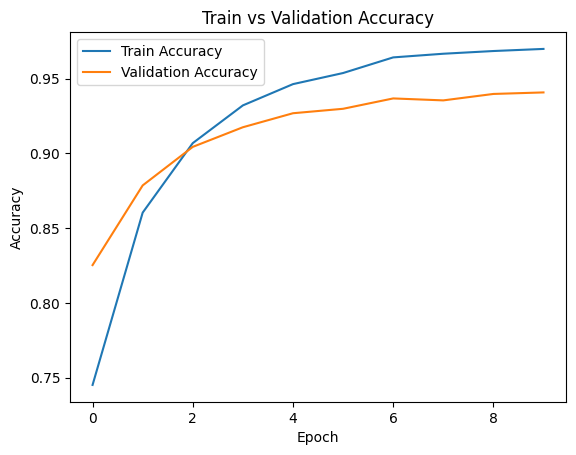

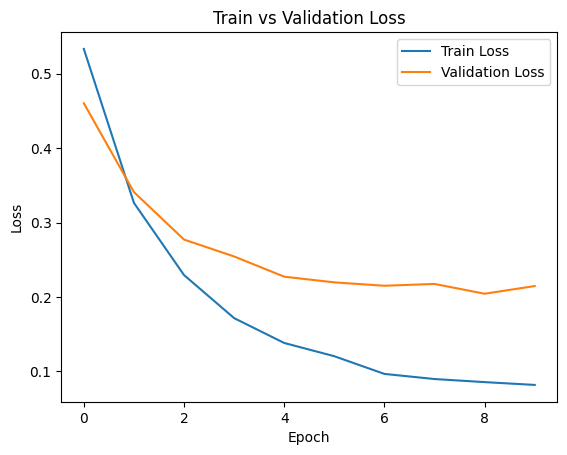

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()
